## Importing necessary packages and data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# Load the necessary data files
swap_discount_curve = pd.read_excel('../data/discount_curve_swaps.xlsx', sheet_name=0, index_col='maturity')

swap_rates_interpolated = pd.read_excel('../data/discount_curve_swaps.xlsx', sheet_name=1, index_col='maturity')

swap_rates_benchmark = pd.read_excel('../data/discount_curve_swaps.xlsx', sheet_name=2, index_col='maturity')

swap_rates_quotes = pd.read_excel('../data/discount_curve_swaps.xlsx', sheet_name=3, index_col='maturity')

In [3]:
# Display few rows of the data for all dataframes
display(swap_discount_curve.head().style.set_caption('Swap Discount Curve'))

display(swap_rates_interpolated.head().style.set_caption('Swap Rates Interpolated'))

display(swap_rates_benchmark.head().style.set_caption('Swap Rates Benchmark'))

display(swap_rates_quotes.head().style.set_caption('Swap Rates Quotes'))

,last update,swap rate,spot disc rate
maturity,,,
2025-10-01 00:00:00,2025-07-28 00:00:00,0.043342,0.044119
2026-01-01 00:00:00,2025-07-28 00:00:00,0.042236,0.042740
2026-04-01 00:00:00,2025-07-28 00:00:00,0.041237,0.041503
2026-07-01 00:00:00,2025-07-28 00:00:00,0.040290,0.040339
2026-10-01 00:00:00,2025-07-28 00:00:00,0.039257,0.039340


,rate,last update
maturity,,
2025-10-01 00:00:00,0.043363,2025-07-28 00:00:00
2026-01-01 00:00:00,0.042287,2025-07-28 00:00:00
2026-04-01 00:00:00,0.041309,2025-07-28 00:00:00
2026-07-01 00:00:00,0.040358,2025-07-28 00:00:00
2026-10-01 00:00:00,0.039303,2025-07-28 00:00:00


,tenor,rate,last update
maturity,,,
2025-08-04 00:00:00,1W,0.043540,2025-07-28 00:00:00
2025-08-11 00:00:00,2W,0.043510,2025-07-28 00:00:00
2025-08-18 00:00:00,3W,0.043510,2025-07-28 00:00:00
2025-08-28 00:00:00,1M,0.043520,2025-07-28 00:00:00
2025-09-28 00:00:00,2M,0.043390,2025-07-28 00:00:00


,2025-06-30 00:00:00
maturity,
0.251882,4.301900
0.503765,4.146650
0.750171,3.999060
0.999316,3.866730
1.251198,3.720500


In [4]:
# Utility Function
def get_year_frac(start_date, end_date):
    """
    Calculates year fraction between dates using ACT/360 convention.
    Ensures output is a float for scalar inputs or numpy array for series.
    """
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Calculate difference in days
    diff = end - start
    
    # Handle both scalar and Series/Index inputs
    if isinstance(diff, pd.Series) or isinstance(diff, pd.Index):
        days = diff.days
    else:
        days = diff.days
        
    return days / 360.0

# Define valuation date (t=0) from the 'last update' column
val_date = pd.to_datetime(swap_discount_curve['last update'].iloc[0])

# Pre-calculate T (maturity in years) for the main dataset
swap_discount_curve['T'] = get_year_frac(val_date, swap_discount_curve.index)
swap_discount_curve = swap_discount_curve.sort_values('T')

## 1. Fitting the SOFR-Swap Discount Curves

### 1.1 Fitting SOFR-Swap Discount Curves with Continuous & Annual Compounding

#### Mathematical Derivation

Let $r_{ann}(T)$ be the annually compounded spot rate for maturity $T$. The discount factor $Z(0,T)$ is:

$$
Z(0,T) = \frac{1}{(1 + r_{ann}(T))^T}
$$

Let $r_{cont}(T)$ be the continuously compounded equivalent. The discount factor is:

$$
Z(0,T) = e^{-r_{cont}(T) \cdot T}
$$

Equating the two discount factors:

$$
e^{-r_{cont}(T) \cdot T} = (1 + r_{ann}(T))^{-T}
$$

Taking the natural logarithm to solve for $r_{cont}(T)$:

$$
r_{cont}(T) = \ln(1 + r_{ann}(T))
$$

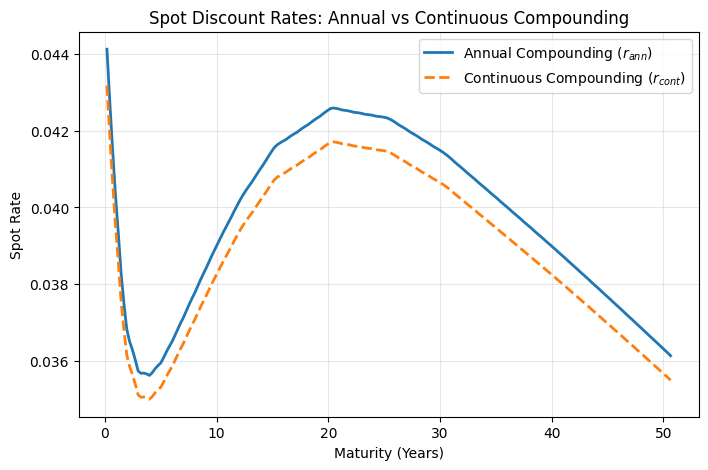

In [5]:
# Extract Annual Rates
r_ann = swap_discount_curve['spot disc rate'].astype(float)

# Convert to Continuous Rates
# r_cont = ln(1 + r_ann)
r_cont = np.log(1 + r_ann)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(swap_discount_curve['T'], r_ann, label='Annual Compounding ($r_{ann}$)', linewidth=2)
plt.plot(swap_discount_curve['T'], r_cont, label='Continuous Compounding ($r_{cont}$)', linestyle='--', linewidth=2)

plt.title('Spot Discount Rates: Annual vs Continuous Compounding')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Store continuous rate back in DF for later use
swap_discount_curve['r_cont'] = r_cont

### 1.2 Discount Factors

#### Mathematical Derivation

Using the annually compounded rates provided:

$$
Z(0,T) = (1 + r_{ann})^{-T}
$$

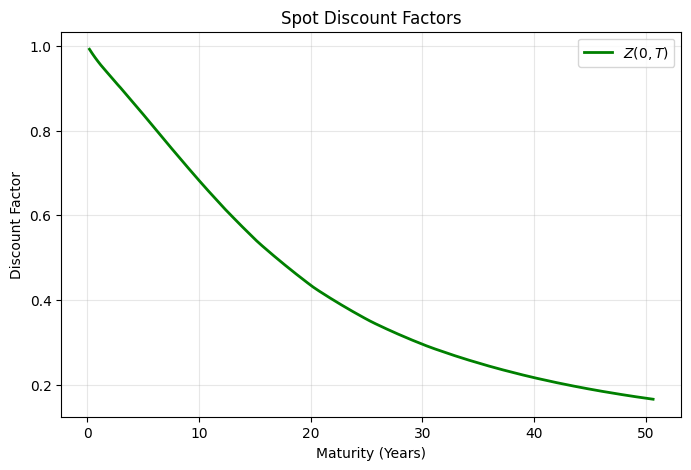

In [6]:
# Calculate Discount Factors
# DF = 1 / (1 + r)^T
discount_factors = 1 / ((1 + r_ann) ** swap_discount_curve['T'])

# Store in DataFrame
swap_discount_curve['discount_factor'] = discount_factors

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(swap_discount_curve['T'], discount_factors, color='green', linewidth=2, label='$Z(0,T)$')

plt.title('Spot Discount Factors')
plt.xlabel('Maturity (Years)')
plt.ylabel('Discount Factor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 1.4 Forward Curve

**Methodology:**  
The forward discount factor $Z(0, T_1, T_2)$ represents the price today of a contract to receive $\$1$ at time $T_2$, with the purchase price paid at time $T_1$.

Under no-arbitrage conditions:
$$
Z(0, T_1, T_2) = \frac{Z(0, T_2)}{Z(0, T_1)}
$$

To find the continuously compounded forward rate $f(T_1, T_2)$ for that interval, we use the relationship:
$$
Z(0, T_1, T_2) = e^{-f(T_1, T_2) \cdot (T_2 - T_1)}
$$

Solving for $f(T_1, T_2)$ by taking the natural logarithm:
$$
f(T_1, T_2) = -\frac{\ln(Z(0, T_1, T_2))}{T_2 - T_1}
$$

This approach first determines the forward discount factor (which is the "price" of the forward interval) and then converts it to a forward rate, which is equivalent to the difference in the logs of the spot discount factors.

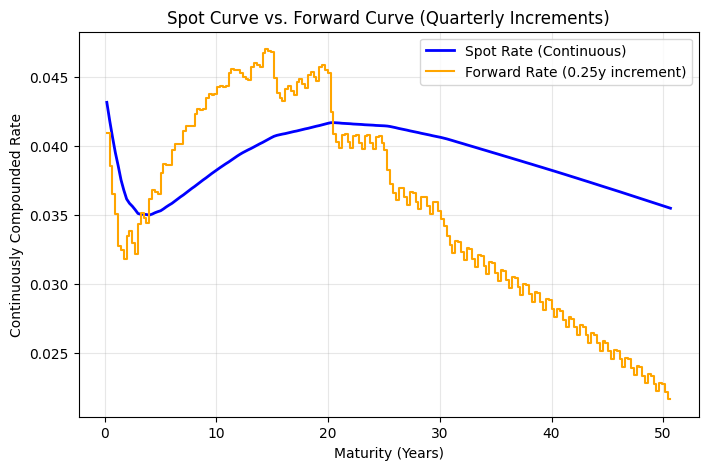

In [7]:
# Forward Curve Calculation
# Copy the DataFrame
df_fwd = swap_discount_curve.copy()

# Calculate forward discount factors: Z(0, T_curr) / Z(0, T_prev)
df_fwd['fwd_factor'] = df_fwd['discount_factor'] / df_fwd['discount_factor'].shift(1)

# Time difference between adjacent maturities
df_fwd['dT'] = df_fwd['T'].diff()

# Continuously compounded forward rate for each interval
df_fwd['fwd_rate'] = -np.log(df_fwd['fwd_factor']) / df_fwd['dT']

# Plot spot curve and forward curve
plt.figure(figsize=(8, 5))
plt.plot(df_fwd['T'], df_fwd['r_cont'], label='Spot Rate (Continuous)', color='blue', linewidth=2)
plt.step(df_fwd['T'], df_fwd['fwd_rate'], where='pre', label='Forward Rate (0.25y increment)', color='orange')
plt.title('Spot Curve vs. Forward Curve (Quarterly Increments)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Continuously Compounded Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 1.5 Forward Factors and Spot Rates at $t = 2.0$ and $t = 2.25$

### 2. Spot Discount Rates and Associated Spot Discount Factors

**Mathematical Derivation:**

To obtain the required values at $t = 2.0$ and $t = 2.25$, we interpolate the logarithm of the discount factors. Linear interpolation on $\log(\text{DF})$ ensures arbitrage-free, piecewise-constant forward rates between nodes.

- **Spot Discount Factors:**  
  We interpolate $\log Z(0,T)$ to compute $Z(0,2.0)$ and $Z(0,2.25)$.

- **Forward Discount Factor:**  
  The forward discount factor for moving from $T_1 = 2.0$ to $T_2 = 2.25$ is given by:
  $$
  Z(2.0, 2.25) = \frac{Z(0, 2.25)}{Z(0, 2.0)}
  $$

,"Discount Factor Z(0,T)",Spot Rate (Annual)
Maturity (T),,
2.000000,0.930335,0.036765
2.250000,0.922569,0.036468


,,"Forward Factor Z(T1, T2)"
Forward Start (T1),Forward End (T2),
2.000000,2.250000,0.991653


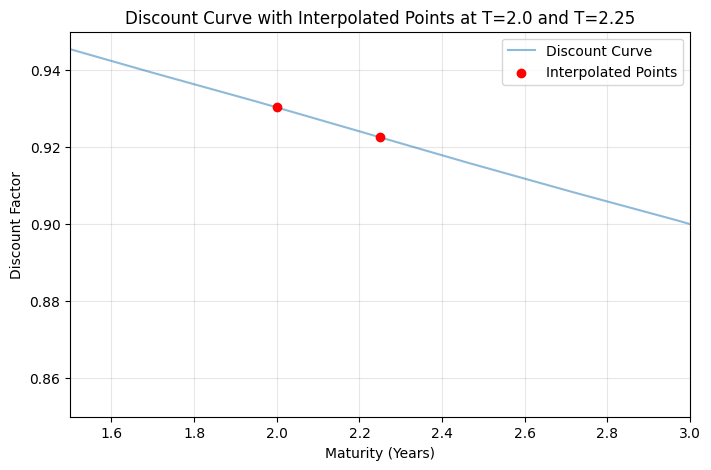

In [8]:
# Interpolate Log(Z) vs T
log_z_interp = interp1d(
    swap_discount_curve['T'], 
    np.log(swap_discount_curve['discount_factor']), 
    kind='linear', 
    fill_value='extrapolate'
)

def get_discount_factor(t):
    """Interpolated discount factor at time t using log-linear interpolation."""
    return np.exp(log_z_interp(t))

# Define start and end maturities
t_start = 2.00
t_end = 2.25

# Calculate interpolated spot discount factors
Z_start = get_discount_factor(t_start)
Z_end = get_discount_factor(t_end)

# Calculate spot rates (annual compounding) from derived discount factors
r_spot_start = (1 / Z_start)**(1 / t_start) - 1
r_spot_end = (1 / Z_end)**(1 / t_end) - 1

# Calculate forward discount factor
forward_factor = Z_end / Z_start

# Organize results in DataFrames for clean display
df_spot = pd.DataFrame({
    'Maturity (T)': [t_start, t_end],
    'Discount Factor Z(0,T)': [Z_start, Z_end],
    'Spot Rate (Annual)': [r_spot_start, r_spot_end]
}).set_index('Maturity (T)')
df_spot = df_spot.style.set_caption('Interpolated Spot Discount Factors and Spot Rates (Annual Compounding)')

df_forward = pd.DataFrame({
    'Forward Start (T1)': [t_start],
    'Forward End (T2)': [t_end],
    'Forward Factor Z(T1, T2)': [forward_factor]
}).set_index(['Forward Start (T1)', 'Forward End (T2)'])
df_forward = df_forward.style.set_caption(f'Forward Discount Factor Z({t_start}, {t_end})')

display(df_spot)
display(df_forward)

# Plotting (zoomed-in)
plt.figure(figsize=(8, 5))
plt.plot(
    swap_discount_curve['T'], swap_discount_curve['discount_factor'], 
    label='Discount Curve', alpha=0.5
)
plt.scatter([t_start, t_end], [Z_start, Z_end], color='red', zorder=5, label='Interpolated Points')
plt.title(f'Discount Curve with Interpolated Points at T={t_start} and T={t_end}')
plt.xlabel('Maturity (Years)')
plt.ylabel('Discount Factor')
plt.xlim(1.5, 3.0)
plt.ylim(0.85, 0.95)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 3. Interpolating Swap Rates

### The Bootstrapping Formula

The formula for deriving the discount factor from par swap rates is:

$$
Z(0,T) = \frac{1 - S(T) \sum_{i=1}^{k} \alpha_i Z(0, t_i)}{1 + S(T) \,\alpha_{\text{stub}}}
$$

where:

- $S(T)$ = par swap rate for maturity $T$  
- $t_i$ = annual coupon payment dates prior to $T$  
- $\alpha_i$ = accrual factor for each period (assumed $\approx 1$ for annual, but calculated exactly for the stub period)  
- $\alpha_{\text{stub}}$ = accrual factor of the final (possibly stub) period

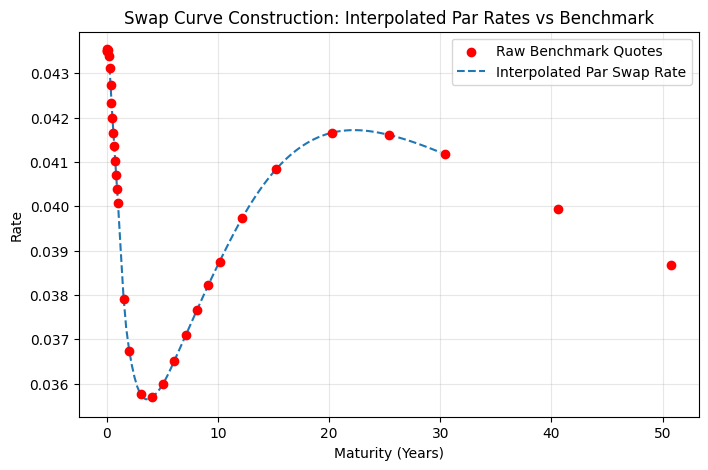

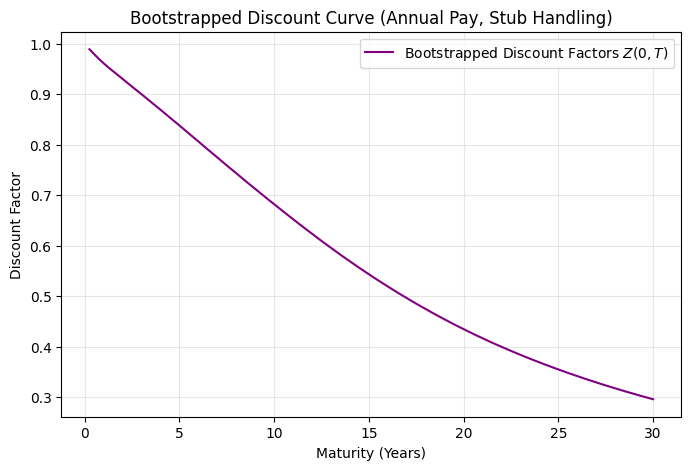

In [9]:
# Prepare benchmark data (calculate year fraction)
bmk = swap_rates_benchmark.copy()
bmk['T'] = get_year_frac(val_date, bmk.index)  # Calculate maturity in years from valuation date
bmk = bmk.sort_values('T')

# Interpolate par swap rates using cubic spline for smoothness
par_rate_interp = interp1d(bmk['T'], bmk['rate'], kind='cubic', fill_value='extrapolate')

# Define grid of maturities (every quarter out to 30 years)
grid_T = np.arange(0.25, 30.25, 0.25)
grid_rates = par_rate_interp(grid_T)

# Bootstrap discount factors (annual payments, handling stub periods)
bootstrapped_dfs = {}

for T, S in zip(grid_T, grid_rates):
    T_rounded = round(T, 4)
    floor_T = int(np.floor(T))
    # List regular payment dates and include stub at T if necessary
    pay_dates = list(range(1, floor_T + 1))
    if T != floor_T and T > 0:
        pay_dates.append(T)
    elif T == floor_T and floor_T > 0:
        pass  # no stub, integer maturity

    sum_prev_PV = 0.0
    for t_pay in pay_dates[:-1]:
        t_key = round(t_pay, 4)
        if t_key in bootstrapped_dfs:
            accrual = 1.0  # Annual frequency assumed
            sum_prev_PV += accrual * bootstrapped_dfs[t_key]
        # If missing, skip; should not happen with dense grid

    # Calculate the accrual for the final period (stub if not annual)
    last_interval_start = pay_dates[-2] if len(pay_dates) > 1 else 0.0
    alpha_last = T - last_interval_start

    # Bootstrapping formula: Z(T) = (1 - S * sum_prev_PV) / (1 + S * alpha_last)
    Z_T = (1 - S * sum_prev_PV) / (1 + S * alpha_last)
    bootstrapped_dfs[T_rounded] = Z_T

# Convert results to DataFrame
df_boot = pd.DataFrame({
    'T': list(bootstrapped_dfs.keys()),
    'Z_boot': list(bootstrapped_dfs.values()),
})
df_boot['par_rate'] = par_rate_interp(df_boot['T'])

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(bmk['T'], bmk['rate'], color='red', label='Raw Benchmark Quotes', zorder=5)
plt.plot(df_boot['T'], df_boot['par_rate'], label='Interpolated Par Swap Rate', linestyle='--')
plt.title('Swap Curve Construction: Interpolated Par Rates vs Benchmark')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(df_boot['T'], df_boot['Z_boot'], color='purple', label=r'Bootstrapped Discount Factors $Z(0,T)$')
plt.title('Bootstrapped Discount Curve (Annual Pay, Stub Handling)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Discount Factor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()